# Importing libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

In [4]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

# Functions

# Importing Data

In [7]:
#start_date=datetime.datetime(2020,1,1)
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()

In [8]:
days=(today-start_date).days
days

1861

In [9]:
remaining=days%500
numbers_of_table=days//500

In [10]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:30].to_list()

In [11]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(days))
data=Binance.get_price(tickers,temp_end)
prices=prices.combine_first(data)
prices=prices.sort_index()
prices = prices[~prices.index.duplicated(keep='first')]

In [12]:
returns=np.log(1+prices.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()

C:\Users\niroo\AppData\Local\Temp\ipykernel_194964\2972560492.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns=np.log(1+prices.pct_change())


In [13]:
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)

In [14]:
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

# Strategy Backtesting

In [16]:
month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

In [17]:
returns_to_use

,ADAUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETCUSDT,ETHUSDT,HBARUSDT,LINKUSDT,LTCUSDT,TRXUSDT,USDCUSDT,XLMUSDT,XRPUSDT
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,0.018997,-0.000391,0.000168,0.000781,0.005448,0.002000,0.012388,0.010685,0.024481,0.007718,-0.006033,-0.000100,0.007535,0.000518
2020-01-02,-0.023879,-0.044765,-0.052981,-0.033200,-0.014629,-0.063055,-0.027758,-0.033402,-0.042005,-0.054054,-0.029166,-0.000798,-0.037800,-0.029170
2020-01-03,0.044279,0.129103,0.047792,0.053015,0.014184,0.079200,0.054766,0.033402,0.038077,0.068604,0.045670,-0.001597,0.045936,0.030878
2020-01-04,0.004963,0.009130,0.011786,0.001245,0.016808,0.039206,-0.001117,0.070859,0.011135,0.012940,0.000000,-0.000300,-0.000219,-0.001708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,-0.017452,-0.024451,-0.000089,-0.022143,-0.007965,0.020712,0.016371,-0.029427,0.028614,-0.015954,0.007120,0.000300,-0.034175,-0.029692
2025-02-01,-0.052360,-0.048790,-0.036880,-0.017669,-0.065914,-0.072246,-0.057178,-0.073376,-0.091029,-0.081710,-0.037755,-0.000100,-0.054577,-0.053548
2025-02-02,-0.105510,-0.114200,-0.055320,-0.029599,-0.138555,-0.103759,-0.082844,-0.118143,-0.116153,-0.078575,-0.080077,0.000000,-0.102475,-0.109237
2025-02-03,0.008410,-0.020180,-0.000955,0.036460,0.060677,-0.020203,0.003555,0.081882,0.056072,-0.020461,0.014091,-0.001200,0.045557,0.045499


In [18]:
results={}
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0]
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

In [19]:
for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}])#,constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.30},
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass
    
rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
 

In [20]:
tracking={}
portfolio={}
investment_amount=1000
initial_amount=investment_amount
perf=dataframe.pct_change()
transaction_fee=0.005

weight_dict={col: 1/returns_to_use.shape[1] for col in returns_to_use.columns}


for i in range(len(dates_end)-1):
    
    print(dates_end[i],investment_amount,investment_amount/initial_amount)

    
    temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
    initial_price=temp.iloc[0].to_dict()

    if dates_end[i]>dates_end[0]:

        top50=rolling_optimization.loc[dates_end[i]]
        top50_dict=rolling_optimization.loc[dates_end[i]].to_dict()
        weight_dict={}

        for key in temp.columns:

            if key in top50_dict: 
                weight_dict[key]=top50_dict[key]
            else:
                weight_dict[key]=0
      
                
    weight_vec=np.array(list(weight_dict.values()))
    
    inital_investment_per_stock={}
    shares={}

    for col in temp.columns:
        
        weighted_perf=weight_vec*perf.loc[dates_end[i]]
        
        inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
        shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

    tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

    temp=temp*shares    
    portfolio[dates_end[i]]=temp
    investment_amount=temp.iloc[-1].sum()
    

temp=dataframe.loc[dates_end[-2]:]*shares
portfolio[dates_end[-1]]=temp

C:\Users\niroo\AppData\Local\Temp\ipykernel_194964\3371734425.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  perf=dataframe.pct_change()


2020-01-01 00:00:00 1000 1.0
2020-01-31 00:00:00 1472.3626181493273 1.4723626181493272
2020-02-28 00:00:00 2000.8122581098812 2.0008122581098813
2020-03-31 00:00:00 1446.407429633718 1.446407429633718
2020-04-30 00:00:00 1949.9436041194751 1.949943604119475
2020-05-29 00:00:00 1991.9836148171862 1.991983614817186
2020-06-30 00:00:00 1862.2055766784156 1.8622055766784156
2020-07-31 00:00:00 2588.6085822746263 2.5886085822746265
2020-08-31 00:00:00 2808.0438527376605 2.8080438527376606
2020-09-30 00:00:00 2622.700322302416 2.6227003223024163
2020-10-30 00:00:00 2964.462538938451 2.964462538938451
2020-11-30 00:00:00 3977.893797757806 3.9778937977578064
2020-12-31 00:00:00 5129.366911065281 5.129366911065281
2021-01-29 00:00:00 8179.096996212478 8.179096996212477
2021-02-26 00:00:00 33896.42833205482 33.89642833205482
2021-03-31 00:00:00 44910.59655311407 44.91059655311407
2021-04-30 00:00:00 99626.80124072781 99.62680124072781
2021-05-31 00:00:00 77822.15679361465 77.82215679361465
2021-

In [21]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])

In [22]:
historical_portfolio.sum(axis=1)

2020-01-01      1001.034526
2020-01-02       966.954542
2020-01-03      1015.443425
2020-01-04      1028.322499
2020-01-05      1036.207733
                  ...      
2025-01-31    528629.464353
2025-02-01    506856.893394
2025-02-02    479987.009438
2025-02-03    480140.884889
2025-02-04    456962.038465
Length: 1862, dtype: float64

<Axes: >

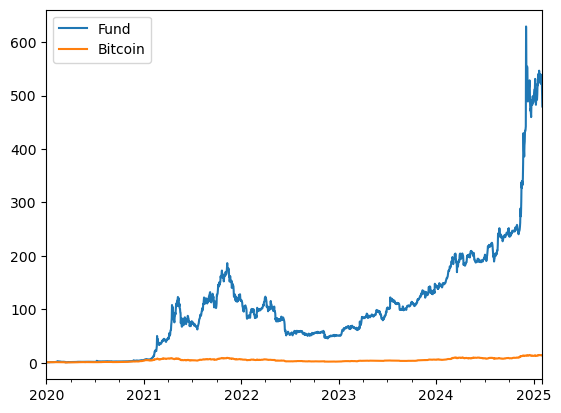

In [23]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[:-2]).cumprod().plot()

In [24]:
years=sorted(list(set(performance.index.year)))

month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

<Axes: >

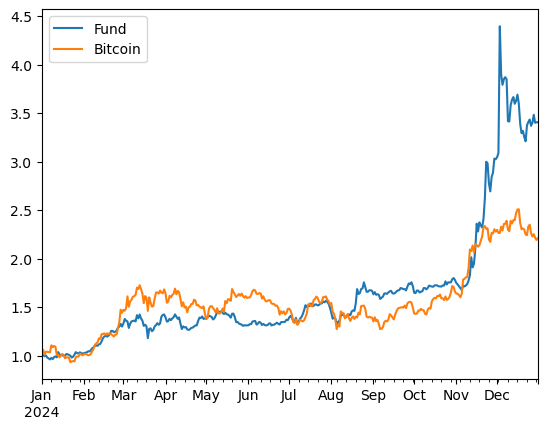

In [25]:
(1+performance_pct.loc['2024']).cumprod().plot()

In [26]:
year_returns={}
for year in years:

    perf_year=performance.loc[str(year)].iloc[-1]/performance.loc[str(year)].iloc[0]-1
    year_returns[year]=perf_year

year_returns[years[-1]]=performance.loc[str(years[-1])].iloc[-2]/performance.loc[str(years[-1])].iloc[0]-1

In [27]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2020,2021,2022,2023,2024,2025
Fund,4.124066,21.379449,-0.562080,1.804248,2.387444,-0.028808
Bitcoin,3.016697,0.575665,-0.653364,1.544636,1.118084,0.071219


In [28]:
month_returns={}
for month in month_year:

    perf_year=performance.loc[str(month)].iloc[-1]/performance.loc[str(month)].iloc[0]-1
    month_returns[month]=perf_year

month_returns[month]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-1])].iloc[0]-1

In [29]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02
Fund,0.470841,0.283600,-0.248649,0.305888,0.010055,-0.106718,0.389475,0.014132,-0.079378,0.144179,...,-0.047804,0.040434,0.073699,0.156269,0.051515,0.079711,0.727260,0.118214,0.069271,-0.052709
Bitcoin,0.298859,-0.091746,-0.248649,0.297622,0.070388,-0.104131,0.227844,-0.012851,-0.096073,0.298694,...,0.157201,-0.073706,0.027472,-0.097623,0.105158,0.156009,0.387245,-0.037137,0.082859,0.006885


In [30]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['Bitcoin']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['Bitcoin'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['Bitcoin'].iloc[-2]/performance['Bitcoin'].iloc[0]
metrics['Sharpe Ratio']=metrics['Fund Return']/metrics['Fund Vol']

In [31]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.584834
Fund Vol,0.752008
Bench Vol,0.537708
Fund Return,479.644680
Bench Return,14.071744
Sharpe Ratio,637.818438


In [32]:
tracking[dates_end[13]][0]

{'ADAUSDT': 0.0,
 'BCHUSDT': 0.0,
 'BNBUSDT': 0.703887,
 'BTCUSDT': 0.0,
 'DOGEUSDT': 0.0,
 'ETCUSDT': 0.0,
 'ETHUSDT': 0.0,
 'HBARUSDT': 0.063532,
 'LINKUSDT': 0.0,
 'LTCUSDT': 0.0,
 'TRXUSDT': 0.116045,
 'USDCUSDT': 0.0,
 'XLMUSDT': 0.0,
 'XRPUSDT': 0.116536}

In [33]:
dates_end[13]

Timestamp('2021-01-29 00:00:00')